# Frozen lake : Reinforcement Learning
![ Frozen lake](images/frozen_lake.gif) 

For the first part of the project we will tackle the frozen lake Envirement which involves crossing a frozen lake from the start position to a predetermined goal without falling into any holes. The solution isn't deterministic as the player can slip on the ice.
 
## Envirement description : 

### 1. Action Space
The action shape is as follows : 
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### 2. Observation Space
The observation is a value representing the player’s current position= and it ranges from 0 to the map's width*height-1.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map.

### 4. Rewards : 
Reward can be defined as follows : 
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### 5. Episode End : 
The episode ends if the following happens:
- Termination:
    - The player moves into a hole.
    - The player reaches the goal at max(width) * max(height) - 1 (location [width-1, height-1]).
- Truncation :
    - The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.


Uploading the necessary libraries and modules needed for our experiment.

In [51]:
import gymnasium as gym
#from tools.qlearning import *
import numpy as np
import matplotlib.pyplot   as plt
import pandas as pd

We will experiment with both conditions `is_slippery=True` and `is_slippery=False`

In [38]:
# To speed up the process we will set the render_mode as None.
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

# 1. Algorithms
### 1.1 Q-Learning

In [39]:
import numpy as np
from tqdm import *
def q_train(env, alpha=0.99, gamma=0.9, max_n_steps=100, n_episodes=10000, weights="data/q_table.npy"):
    """ Q-learning algorithm 
    
    """
    rewards =[]
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, truncated , info = env.step(a) # Take action a and observe the reward and next state s_new and reward r
            #print(s, a, r, s_new, done)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s = s_new
            total_reward = total_reward + r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))

    return q_table



In [40]:
q_table = q_train(env, weights="q_table.npy")
np.save('q_table.npy', q_table)

Loading Q-table saved weights...
Starting Q-learning algorithm...


100%|██████████| 100000/100000 [00:48<00:00, 2071.17it/s]

Finished Q-learning algorithm.
Average reward is : 0.0


### 1.2 Q-Learning ( $\epsilon-greedy$)

$\epsilon-greedy$ is an good strategy for balancing exploration and exploitation.

In [41]:
def q_train_greedy(env, alpha=0.8, gamma=0.95, epsilon=0.05, max_n_steps=100, n_episodes=10001000000, weights="data/q_table.npy"):
    """ Q-learning algorithm (epsilon-greedy)
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [42]:
q_table_greedy = q_train_greedy(env,weights="data/q_table_greedy.npy")
np.save('data/q_table_greedy.npy', q_table_greedy)

Loading Q-table saved weights...
Starting Q-learning algorithm...


100%|██████████| 100000/100000 [02:11<00:00, 762.24it/s]

Finished Q-learning algorithm.
Average reward is : 0.27235620018028783



### 1.3 Q-learning epsilon decay
The concept of decay : 
During the lifecycle of an agent that does not have sufficient information on its environment, exploration is more important than exploitation. Once the agent has enough information about the environment, we can then start to exploit that information to improve the agent's performance [Source](https://arxiv.org/pdf/1910.13701.pdf). That's why we'll use the concept of decay by starting with a maximum value of epsilon and then decaying it gradually across every episode. 



In [43]:

def q_train_greedy_decay(env, alpha=0.8, gamma=0.9,min_epsilon=0.005, decay_rate=0.001, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy) with exponential epsilon decay
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []
    epsilon = 1
    
    print("Starting Q-learning algorithm...")
    for episode in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)

            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                # Epsilon exponential decay
                epsilon = min_epsilon + (1-min_epsilon)*np.exp(-decay_rate*episode)
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [44]:
q_table_greedy_decay=q_train_greedy_decay(env, weights="data/q_table_greedy_decay.npy")
np.save("data/q_table_greedy_decay.npy", q_table_greedy)

Loading Q-table saved weights...
Starting Q-learning algorithm...


100%|██████████| 100000/100000 [03:18<00:00, 503.37it/s]

Finished Q-learning algorithm.
Average reward is : 0.5164906750722353


### 1.4 SARSA

In [59]:
def sarsa_train(env, alpha=0.1, gamma=1, epsilon=0.5, episodes=10000, steps=1000) :

    num_actions = env.action_space.n
    num_states = env.observation_space.n
    q = np.zeros((num_states, num_actions))

    for ep in trange(episodes) : 
        
        env.reset()
        state = env.s

        
        if np.random.uniform() < epsilon :
            action = env.action_space.sample()
        else :
            action = np.argmax(q[state, :])
            
        for _ in range(steps) :
            nw_state, reward, terminated, truncated, info = env.step(action)
            
            if np.random.uniform() < epsilon :
                nw_action = env.action_space.sample()
            else :
                nw_action = np.argmax(q[nw_state, :])
                
            q[state, action] = (1-alpha)*q[state, action] + \
                alpha*(reward + gamma*q[nw_state, nw_action])
                
            state = nw_state
            action = nw_action
            
            if terminated or truncated :
                break
    
    env.close()
    
    return q

In [ ]:
sarsa_table = sarsa_train(env, alpha = 0.1, gamma = 1, epsilon = 0.5, episodes = 10000, steps = 1000)

100%|██████████| 10000/10000 [00:03<00:00, 3239.24it/s]


In [ ]:
sarsa_table

array([[0.36891058, 0.41185842, 0.31384139, 0.37521863],
       [0.35361373, 0.        , 0.41221516, 0.34212102],
       [0.3252032 , 0.42384812, 0.33385528, 0.33779337],
       [0.4019159 , 0.        , 0.25490529, 0.2602109 ],
       [0.36953254, 0.50235119, 0.        , 0.37332153],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.63962134, 0.        , 0.40252542],
       [0.        , 0.        , 0.        , 0.        ],
       [0.52132867, 0.        , 0.69743288, 0.38572916],
       [0.48848103, 0.82522238, 0.71084374, 0.        ],
       [0.61458226, 0.90921673, 0.        , 0.48671253],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.78306854, 0.91275251, 0.6627036 ],
       [0.67717062, 0.89781978, 1.        , 0.66799847],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
reward_sarsa, success_rate_sarsa, avg_nb_steps_sarsa = agent_play(env, sarsa_table)

100%|██████████| 100000/100000 [00:10<00:00, 9696.62it/s]

Success rate is = 100.0 %
Average number of steps to succeed is = 6.0


## 2. comparaison

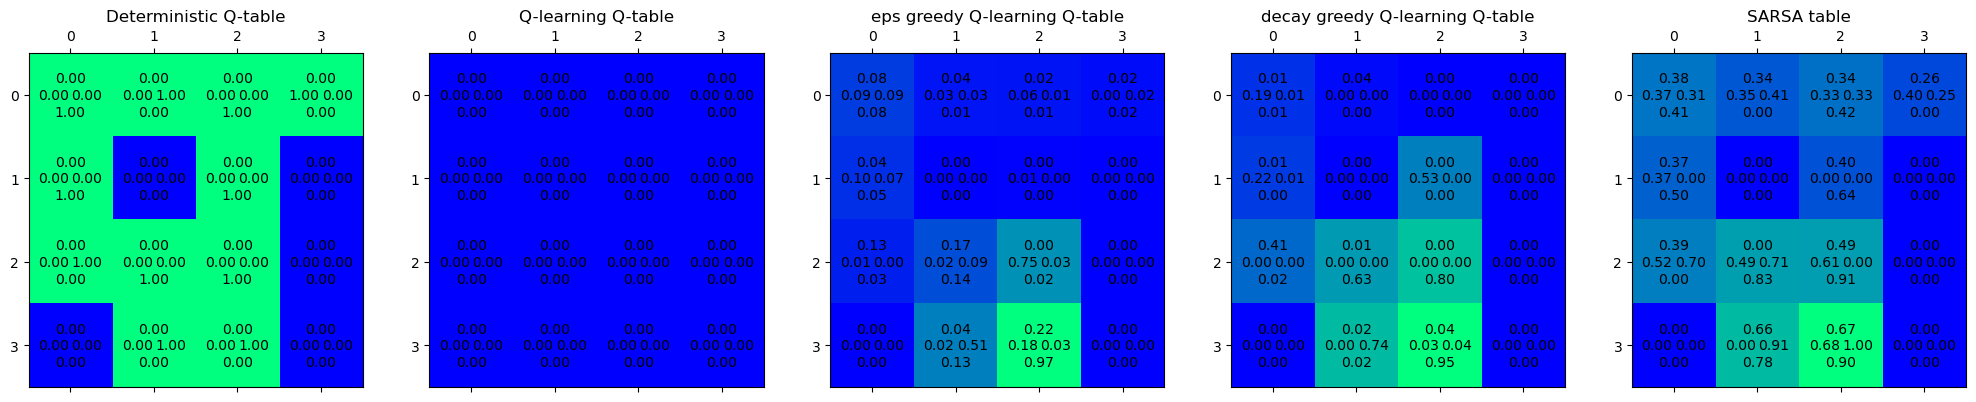

In [ ]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
plt.title("Q-table of the game")

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title("Deterministic Q-table")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title("Q-learning Q-table")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title("eps greedy Q-learning Q-table")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title("decay greedy Q-learning Q-table")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title("SARSA table")
plt.show()

Then we'll define a play function for our game to test the performance

In [57]:
def agent_play(env,q_table, max_n_episodes=10000, max_steps=100):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_steps):
            a = np.argmax(q_table[s])
            s, r, done, _,_ = env.step(a)
            total_reward+=r
            if done: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    success_rate = np.mean(rewards)
    avg_num_steps = np.mean(num_steps)
    print(f'Success rate is = {100*success_rate} %')
    print(f'Average number of steps to succeed is = {avg_num_steps}')
    return rewards, success_rate, avg_num_steps

In [60]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table)


100%|██████████| 10000/10000 [00:01<00:00, 9940.92it/s]


Success rate is = 4.17 %
Average number of steps to succeed is = 5.0541


100%|██████████| 10000/10000 [00:03<00:00, 2511.51it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.93225935561337


100%|██████████| 10000/10000 [00:04<00:00, 2351.88it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.84112523776154


100%|██████████| 10000/10000 [00:05<00:00, 1910.01it/s]


Success rate is = 52.00653528030226 %
Average number of steps to succeed is = 28.741345859287247


100%|██████████| 10000/10000 [00:03<00:00, 3301.14it/s]

Success rate is = 0.0 %
Average number of steps to succeed is = 17.91853482786229


/tmp/ipykernel_57852/995146866.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
/tmp/ipykernel_57852/995146866.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
/tmp/ipykernel_57852/995146866.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
/tmp/ipykernel_57852/995146866.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-

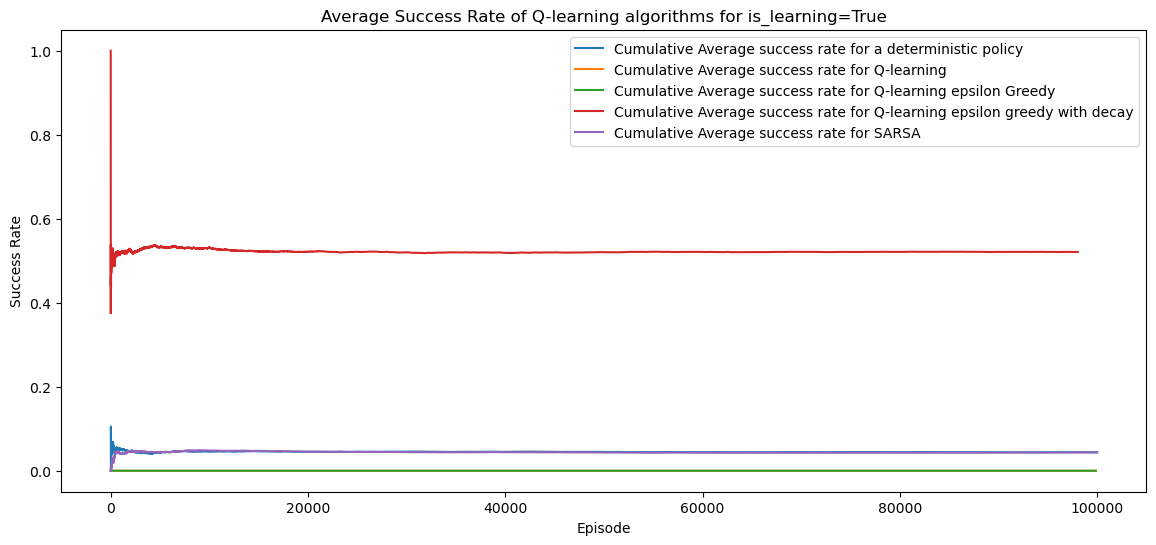

In [50]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=True')
plt.legend()
plt.show()

## 3. Hyperparameter tuning

In [85]:
# Qlearning optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.59]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]

alphas=[]
success_rates = []
gammas=[]
epsilons=[]

for al in alpha :
    for ga in gamma :
            q_table = q_train(env, alpha=al, gamma=ga)
            reward, success_rate, avg_nb_steps = agent_play(env, q_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)



Loading Q-table saved weights...
Starting Q-learning algorithm...


 20%|██        | 20064/100000 [00:22<01:29, 889.42it/s] 


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame()
df["alpha"]=alphas
df["gamma"]=gammas
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,eps,alpha,gamma,success_rate
23,0.50,0.05,0.95,0.781998
22,0.10,0.05,0.95,0.779391
38,0.10,0.10,0.95,0.774100
30,0.10,0.05,1.00,0.770606
2,0.10,0.01,0.90,0.722275
...,...,...,...,...
1,0.05,0.01,0.90,0.000000
33,0.05,0.10,0.90,0.000000
36,0.01,0.10,0.95,0.000000
37,0.05,0.10,0.95,0.000000


In [ ]:
df.iloc[0]

eps             0.500000
alpha           0.050000
gamma           0.950000
success_rate    0.781998
Name: 23, dtype: float64

In [ ]:
q_table = q_train(env, alpha = 0.05, gamma = 0.95,episodes = 100000, steps = 100)

100%|██████████| 100000/100000 [00:36<00:00, 2717.80it/s]


In [ ]:
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table, max_n_episodes=100000)


100%|██████████| 100000/100000 [01:26<00:00, 1158.15it/s]

In [61]:
# SARSA optimization
alpha = [0.01, 0.05, 0.1, 0.5]
gamma = [0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]

alphas=[]
success_rates = []
gammas=[]
epsilons=[]

for al in alpha :
    for ga in gamma :
        for eps in epsilon :
            sarsa_table = sarsa_train(env, al, ga, eps, episodes = 10000, steps = 100)
            reward, success_rate, avg_nb_steps = agent_play(env, sarsa_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(eps)



100%|██████████| 10000/10000 [00:02<00:00, 3501.99it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.005105105105105


100%|██████████| 10000/10000 [00:02<00:00, 3533.39it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.99469310103134


100%|██████████| 10000/10000 [00:06<00:00, 1611.01it/s]


Success rate is = 72.22745837260446 %
Average number of steps to succeed is = 36.3610849303592


100%|██████████| 10000/10000 [00:05<00:00, 1956.13it/s]


Success rate is = 13.203766780204369 %
Average number of steps to succeed is = 20.882288118613506


100%|██████████| 10000/10000 [00:04<00:00, 2350.89it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.998697916666668


100%|██████████| 10000/10000 [00:04<00:00, 2243.87it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.744770293263937


100%|██████████| 10000/10000 [00:04<00:00, 2375.88it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.657654951436868


100%|██████████| 10000/10000 [00:04<00:00, 2042.04it/s]


Success rate is = 18.993180906538306 %
Average number of steps to succeed is = 21.51554352186121


100%|██████████| 10000/10000 [00:04<00:00, 2404.94it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.843659293364027


100%|██████████| 10000/10000 [00:04<00:00, 2273.99it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.89351898226986


100%|██████████| 10000/10000 [00:02<00:00, 3576.49it/s]


Success rate is = 4.6899999999999995 %
Average number of steps to succeed is = 12.2206


100%|██████████| 10000/10000 [00:09<00:00, 1097.93it/s]


Success rate is = 50.580618641455146 %
Average number of steps to succeed is = 31.78080361730552


100%|██████████| 10000/10000 [00:03<00:00, 2668.47it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.833333333333332


100%|██████████| 10000/10000 [00:03<00:00, 2533.13it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.910411864916323


100%|██████████| 10000/10000 [00:02<00:00, 4269.24it/s]


Success rate is = 6.21 %
Average number of steps to succeed is = 9.7742


100%|██████████| 10000/10000 [00:07<00:00, 1375.74it/s]


Success rate is = 27.298587828913952 %
Average number of steps to succeed is = 28.35995123437976


100%|██████████| 10000/10000 [00:02<00:00, 3580.49it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.672574346650645


100%|██████████| 10000/10000 [00:06<00:00, 1514.83it/s]


Success rate is = 67.87924045231492 %
Average number of steps to succeed is = 36.49530616599104


100%|██████████| 10000/10000 [00:03<00:00, 3225.34it/s]


Success rate is = 18.026223601241117 %
Average number of steps to succeed is = 17.920628565709137


100%|██████████| 10000/10000 [00:05<00:00, 1908.40it/s]


Success rate is = 32.30160340978283 %
Average number of steps to succeed is = 27.633346864217575


100%|██████████| 10000/10000 [00:03<00:00, 2972.36it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.925325325325325


100%|██████████| 10000/10000 [00:05<00:00, 1974.87it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.657494496698018


100%|██████████| 10000/10000 [00:08<00:00, 1183.05it/s]


Success rate is = 77.93913507741591 %
Average number of steps to succeed is = 37.158889482114255


100%|██████████| 10000/10000 [00:08<00:00, 1148.37it/s]


Success rate is = 78.19976397382256 %
Average number of steps to succeed is = 37.16832957837142


100%|██████████| 10000/10000 [00:04<00:00, 2375.51it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.688719847863076


100%|██████████| 10000/10000 [00:03<00:00, 2544.79it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.142599639495295


100%|██████████| 10000/10000 [00:03<00:00, 2510.63it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.169771634615383


100%|██████████| 10000/10000 [00:07<00:00, 1397.58it/s]


Success rate is = 41.53798641136504 %
Average number of steps to succeed is = 31.143504220712373


100%|██████████| 10000/10000 [00:03<00:00, 2549.54it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.047647647647647


100%|██████████| 10000/10000 [00:05<00:00, 1791.12it/s]


Success rate is = 12.494957644211375 %
Average number of steps to succeed is = 25.194735780556677


100%|██████████| 10000/10000 [00:06<00:00, 1572.32it/s]


Success rate is = 77.06058659815885 %
Average number of steps to succeed is = 37.08873902804539


100%|██████████| 10000/10000 [00:06<00:00, 1507.30it/s]


Success rate is = 68.09122881807525 %
Average number of steps to succeed is = 36.97037194926995


100%|██████████| 10000/10000 [00:05<00:00, 1854.11it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.68014816297928


100%|██████████| 10000/10000 [00:05<00:00, 1860.21it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.748323155471017


100%|██████████| 10000/10000 [00:08<00:00, 1221.03it/s]


Success rate is = 68.56011981172443 %
Average number of steps to succeed is = 37.28080872913992


100%|██████████| 10000/10000 [00:02<00:00, 3349.17it/s]


Success rate is = 11.450000000000001 %
Average number of steps to succeed is = 14.1843


100%|██████████| 10000/10000 [00:03<00:00, 2722.86it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.97967357564834


100%|██████████| 10000/10000 [00:03<00:00, 2735.32it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.514766242867154


100%|██████████| 10000/10000 [00:07<00:00, 1363.99it/s]


Success rate is = 77.40999462654486 %
Average number of steps to succeed is = 37.22869425040301


100%|██████████| 10000/10000 [00:03<00:00, 3176.25it/s]


Success rate is = 24.636664327954293 %
Average number of steps to succeed is = 21.413851859276335


100%|██████████| 10000/10000 [00:02<00:00, 3741.03it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.781981981981982


100%|██████████| 10000/10000 [00:02<00:00, 3491.23it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.916199439327194


100%|██████████| 10000/10000 [00:05<00:00, 1988.93it/s]


Success rate is = 50.339576044453594 %
Average number of steps to succeed is = 32.0670919942375


100%|██████████| 10000/10000 [00:04<00:00, 2390.28it/s]


Success rate is = 33.231892878880096 %
Average number of steps to succeed is = 27.770135930208966


100%|██████████| 10000/10000 [00:02<00:00, 3750.72it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.030545818728093


100%|██████████| 10000/10000 [00:03<00:00, 2720.22it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.643450415290705


100%|██████████| 10000/10000 [00:04<00:00, 2287.20it/s]


Success rate is = 22.88661858974359 %
Average number of steps to succeed is = 21.658754006410255


100%|██████████| 10000/10000 [00:05<00:00, 1977.07it/s]


Success rate is = 40.012070006035 %
Average number of steps to succeed is = 23.694327097163548


100%|██████████| 10000/10000 [00:03<00:00, 2767.74it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.73898678414097


100%|██████████| 10000/10000 [00:03<00:00, 2788.39it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.868494795836668


100%|██████████| 10000/10000 [00:03<00:00, 2689.52it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.78286114726199


100%|██████████| 10000/10000 [00:01<00:00, 5679.28it/s]


Success rate is = 6.4399999999999995 %
Average number of steps to succeed is = 9.368


100%|██████████| 10000/10000 [00:02<00:00, 3765.58it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.863863863863862


100%|██████████| 10000/10000 [00:03<00:00, 3299.80it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.035270541082163


100%|██████████| 10000/10000 [00:02<00:00, 3537.47it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.885994790623123


100%|██████████| 10000/10000 [00:03<00:00, 2932.09it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.75826156619267


100%|██████████| 10000/10000 [00:02<00:00, 3345.95it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.82375325455638


100%|██████████| 10000/10000 [00:03<00:00, 2800.80it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.98968968968969


100%|██████████| 10000/10000 [00:02<00:00, 4257.26it/s]


Success rate is = 9.161832366473295 %
Average number of steps to succeed is = 12.59761952390478


100%|██████████| 10000/10000 [00:01<00:00, 5445.30it/s]


Success rate is = 6.4 %
Average number of steps to succeed is = 9.4849


100%|██████████| 10000/10000 [00:03<00:00, 3213.67it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.706855081178592


100%|██████████| 10000/10000 [00:03<00:00, 2941.30it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.93893893893894


100%|██████████| 10000/10000 [00:02<00:00, 4057.21it/s]


Success rate is = 17.18 %
Average number of steps to succeed is = 13.5155


100%|██████████| 10000/10000 [00:04<00:00, 2287.33it/s]

Success rate is = 0.0 %
Average number of steps to succeed is = 17.955555555555556


In [69]:
df = pd.DataFrame()

df["eps"]=epsilons
df["alpha"]=alphas
df["gamma"]=gammas
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,eps,alpha,gamma,success_rate
23,0.50,0.05,0.95,0.781998
22,0.10,0.05,0.95,0.779391
38,0.10,0.10,0.95,0.774100
30,0.10,0.05,1.00,0.770606
2,0.10,0.01,0.90,0.722275
...,...,...,...,...
1,0.05,0.01,0.90,0.000000
33,0.05,0.10,0.90,0.000000
36,0.01,0.10,0.95,0.000000
37,0.05,0.10,0.95,0.000000


In [70]:
df.iloc[0]

eps             0.500000
alpha           0.050000
gamma           0.950000
success_rate    0.781998
Name: 23, dtype: float64

In [81]:
sarsa_table = sarsa_train(env, alpha = 0.05, gamma = 0.95, epsilon = 0.5, episodes = 100000, steps = 100)

100%|██████████| 100000/100000 [00:36<00:00, 2717.80it/s]


In [82]:
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table, max_n_episodes=100000)


100%|██████████| 100000/100000 [01:26<00:00, 1158.15it/s]

Success rate is = 64.12522007042254 %
Average number of steps to succeed is = 39.274361795774645


New frozen lake environment with `is_slippery=False`

In [ ]:
env_no_slip = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

Re-training for the new environment

In [ ]:
q_table = q_train(env_no_slip, weights="q_table.npy")
q_table_greedy = q_train_greedy(env_no_slip,weights="data/q_table_greedy.npy")
q_table_greedy_decay=q_train_greedy_decay(env_no_slip, weights="data/q_table_greedy_decay.npy")
sarsa_table = sarsa_train(env_no_slip, alpha = 0.1, gamma = 1, epsilon = 0.5, episodes = 10000, steps = 1000)

Re-calculating the performance 

In [ ]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_no_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_no_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_no_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_no_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_no_slip, q_table=sarsa_table)

## 3. Conclusion :